### Подключение библиотек

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import KDTree
import random
import matplotlib.pyplot as plt
import time
import pickle

### Теоретический набор датасетов (синтетические)

In [3]:
df_th = pd.read_csv('BD_platelets_regular.csv', sep=';')
df_th

,r,eps,n,beta,0,0.5,1,1.5,2,2.5,...,85.5,86,86.5,87,87.5,88,88.5,89,89.5,90
0,0.5,0.1,1.3725,40,25.301178,25.209944,24.938040,24.490799,23.876934,23.108286,...,0.035687,0.040932,0.046830,0.053408,0.060684,0.068672,0.077375,0.086786,0.096886,0.107647
1,0.5,0.1,1.3725,42,25.253750,25.164614,24.898931,24.461840,23.861731,23.110008,...,0.110150,0.120814,0.131986,0.143610,0.155616,0.167922,0.180437,0.193053,0.205656,0.218120
2,0.5,0.1,1.3725,44,25.202293,25.115267,24.855852,24.428991,23.842764,23.108150,...,0.219127,0.230691,0.241920,0.252689,0.262871,0.272336,0.280954,0.288599,0.295148,0.300487
3,0.5,0.1,1.3725,46,25.143423,25.058531,24.805452,24.388945,23.816780,23.099533,...,0.305602,0.309963,0.313069,0.314847,0.315234,0.314183,0.311665,0.307667,0.302198,0.295287
4,0.5,0.1,1.3725,48,25.076042,24.993305,24.746632,24.340595,23.782681,23.083057,...,0.312300,0.304946,0.296285,0.286385,0.275334,0.263235,0.250206,0.236381,0.221905,0.206933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196139,2.1,1.0,1.3875,82,214711.812500,212251.640600,205016.031300,193427.546900,178150.890600,160037.921900,...,1.374523,1.331677,1.215894,1.043869,0.838637,0.626118,0.431531,0.276193,0.175054,0.135262
196140,2.1,1.0,1.3875,84,214710.484400,212250.328100,205014.765600,193426.375000,178149.843800,160037.015600,...,1.377804,1.336296,1.221435,1.049784,0.844330,0.631035,0.435245,0.278462,0.175858,0.134800
196141,2.1,1.0,1.3875,86,214710.375000,212250.218800,205014.671900,193426.281300,178149.765600,160036.968800,...,1.384726,1.344976,1.231294,1.060079,0.854240,0.639758,0.442089,0.282927,0.177689,0.134010
196142,2.1,1.0,1.3875,88,214711.218800,212251.046900,205015.484400,193427.046900,178150.500000,160037.640600,...,1.388198,1.349743,1.237083,1.066495,0.860799,0.645923,0.447320,0.286726,0.179647,0.133848


In [4]:
# Вывод количества строк с пустыми значениями
rows_with_null = df_th.isnull().any(axis=1).sum()

print("Общее количество строк с пустыми значениями:", rows_with_null)

Общее количество строк с пустыми значениями: 0


In [5]:
# Удаление колонок, у которых не целый шаг (есть точка в названии)
columns_to_remove = [column for column in df_th.columns if re.search(r'\.', column)]
df_th = df_th.drop(columns_to_remove, axis=1)

In [6]:
columns_to_keep = ['r', 'eps', 'n', 'beta'] + [str(column) for column in range(10, 70)]
df_th = df_th[columns_to_keep]

In [7]:
df_th

,r,eps,n,beta,10,11,12,13,14,15,...,60,61,62,63,64,65,66,67,68,69
0,0.5,0.1,1.3725,40,5.404986,3.808764,2.571659,1.663134,1.033201,0.622427,...,0.010525,0.010189,0.010045,0.010038,0.010088,0.010120,0.010080,0.009946,0.009728,0.009456
1,0.5,0.1,1.3725,42,5.638411,4.030185,2.771908,1.836325,1.176848,0.737060,...,0.011863,0.011368,0.011030,0.010794,0.010580,0.010310,0.009933,0.009436,0.008853,0.008250
2,0.5,0.1,1.3725,44,5.882321,4.264443,2.986821,2.025340,1.336760,0.867727,...,0.011067,0.010295,0.009706,0.009280,0.008974,0.008750,0.008606,0.008590,0.008807,0.009414
3,0.5,0.1,1.3725,46,6.136376,4.511734,3.217116,2.231376,1.514552,1.016382,...,0.010346,0.010141,0.010375,0.011107,0.012372,0.014210,0.016693,0.019942,0.024132,0.029482
4,0.5,0.1,1.3725,48,6.400964,4.772917,3.464140,2.456250,1.712453,1.185589,...,0.020578,0.023229,0.026855,0.031591,0.037532,0.044757,0.053344,0.063391,0.075009,0.088314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196139,2.1,1.0,1.3875,82,1469.599243,2256.340088,2440.665527,1890.009033,1041.934204,377.131409,...,2.655303,4.071884,4.389536,3.457527,1.925717,0.737341,0.513016,1.215382,2.256249,2.919008
196140,2.1,1.0,1.3875,84,1469.591797,2256.213867,2440.489990,1889.851685,1041.831787,377.084076,...,2.654903,4.068997,4.384384,3.452344,1.922590,0.736414,0.512291,1.212126,2.248880,2.908152
196141,2.1,1.0,1.3875,86,1469.587891,2256.108643,2440.339111,1889.711792,1041.737183,377.037628,...,2.655852,4.069432,4.382699,3.449078,1.919253,0.733902,0.510052,1.208519,2.242315,2.898185
196142,2.1,1.0,1.3875,88,1469.594604,2256.052246,2440.252686,1889.628784,1041.678711,377.007202,...,2.654766,4.069177,4.381941,3.447446,1.916993,0.731250,0.506809,1.204065,2.235982,2.889730


### Экспериментальные данные

In [8]:
df_ex = pd.read_csv('experimental_1_degree.csv', sep=';')
df_ex

,10,11,12,13,14,15,16,17,18,19,...,61,62,63,64,65,66,67,68,69,70
0,183.176875,166.478693,134.478772,116.654527,98.472286,78.717751,62.504292,57.866845,49.507113,45.329470,...,3.499498,1.986927,2.974273,1.984659,2.357138,0.593534,-0.434256,-0.257839,-1.024817,NaN
1,74.758799,72.793755,65.249161,66.274876,59.231701,61.344619,52.165751,44.154889,41.012489,34.339016,...,1.738917,1.372427,-0.090051,-0.439739,-0.253310,-0.232650,-1.538535,-0.431494,-0.606203,NaN
2,878.528295,608.147687,422.259021,284.829020,174.500711,104.376918,57.810083,37.118711,28.380340,28.736102,...,-0.362481,0.055591,0.368540,-0.222707,-0.043057,-0.447811,0.499172,0.157822,-0.622346,NaN
3,555.969393,431.583247,345.706680,280.833703,231.427627,179.745473,144.822840,124.502582,94.629270,74.394734,...,-1.668954,-1.835357,-2.323255,-1.719203,0.114578,0.697275,0.605574,0.077802,-2.068405,NaN
4,340.091255,268.053440,213.270653,170.341848,128.769485,95.481732,81.011077,53.541826,36.837450,25.841330,...,3.220378,3.556445,2.990620,-0.043619,0.694566,0.544178,0.696334,0.563298,0.477633,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17436,1377.752719,878.281592,546.089727,325.884113,165.992291,78.956887,35.885254,23.970854,26.161488,35.160410,...,0.232498,1.578530,0.033897,-0.162381,1.801963,0.118351,-0.490850,-0.073694,-0.446275,NaN
17437,415.114219,318.059332,250.199157,188.483128,143.479386,103.810106,70.562213,45.839290,26.346305,14.366995,...,-1.202254,-0.668185,-0.696129,-0.934378,-0.484446,-1.597745,-0.911980,-0.575020,-1.264613,NaN
17438,733.036042,478.025693,310.075502,203.592574,106.704587,61.882547,31.124881,23.998593,13.959039,14.616868,...,2.566404,1.094970,-0.177452,0.188462,0.431783,0.806426,0.431566,0.490124,0.228049,NaN
17439,629.617094,426.788555,301.349396,201.641640,127.522228,91.146601,49.339893,33.783408,25.810443,22.322559,...,-1.555994,-1.576180,-1.543946,-1.431338,-1.544538,-1.595316,-1.971180,-1.993319,-2.028271,NaN


In [9]:
# Вывод количества строк с пустыми значениями
rows_with_null = df_ex.isnull().any(axis=1).sum()

print("Общее количество строк с пустыми значениями:", rows_with_null)

Общее количество строк с пустыми значениями: 17441


In [10]:
df_ex = df_ex.drop('70', axis=1)

### Деление на X_train y_train (вариант split быстрый)

In [11]:
X = df_th.iloc[:, 4:]
y = df_th[['r', 'eps', 'n', 'beta']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Переименование df_ex и перемешивание строк
X_exp = df_ex
X_exp = X_exp.sample(frac=1)

In [13]:
# Вывод количества строк с пустыми значениями
rows_with_null = X_train.isnull().any(axis=1).sum()

print("Общее количество строк с пустыми значениями:", rows_with_null)

Общее количество строк с пустыми значениями: 0


### Создаем массив

In [14]:
# Преобразование в массив
X_train_array = X_train.values
X_test_array = X_test.values
y_train_array = y_train.values
y_test_array = y_test.values
X_exp_array = X_exp.values

### Нормализация данных (для алгоритма поиска не используем)

In [65]:
# для расчетов RMSE не нужно нормализовывать
# # Создание экземпляра MinMaxScaler для нормализации X
# scaler_X = MinMaxScaler()
# X_train_scaled = scaler_X.fit_transform(X_train)
# X_test_scaled = scaler_X.transform(X_test)
# X_exp_scaled = scaler_X.transform(X_exp)

# # Создание экземпляра MinMaxScaler для нормализации y
# scaler_y = MinMaxScaler()
# y_train_scaled = scaler_y.fit_transform(y_train)
# y_test_scaled = scaler_y.transform(y_test)

### Нахождение RMSE (минимального расстояния)

#### Метод расчета через append очень долгий (5 строк df_ex из 17к за 15 минут...)

#### Быстрый метод расчета через np

In [117]:
# Создание пустого массива нужной длины для сохранения результатов
rmse_results = np.zeros(X_test_array.shape[0])
index_results = np.zeros(X_test_array.shape[0])

# Проход по каждой строке в X_exp_scaled
for i in tqdm(range(X_test_array.shape[0])):
    # Считывание всех RMSE для одной строки X_test_scaled по X_train_scaled 
    # Нахождение минимального RMSE для каждой строки X_test_scaled 
    rmse = np.sqrt(np.mean(np.square(X_train_array - X_test_array[i, :]), axis=1))
    min_rmse = np.min(rmse)
    min_index = np.argmin(rmse)
    # Создание два массива под RMSE и индекс
    rmse_results[i] = min_rmse
    index_results[i] = min_index

100%|██████████| 39229/39229 [28:20<00:00, 23.06it/s]


In [118]:
# Скачивание rmse_results и index_results в виде файлов
np.savetxt('rmse_results.txt', rmse_results)
np.savetxt('index_results.txt', index_results)

In [15]:
# Чтение файлов, чтобы повторно не прогонять RMSE
rmse_results = np.loadtxt('rmse_results.txt')
index_results = np.loadtxt('index_results.txt')

In [16]:
print(index_results.shape)
print(rmse_results.shape)

(39229,)
(39229,)


In [17]:
# Создание пустого массива для сохранения предсказанных значений
y_test_pred_array = np.zeros(y_test_array.shape)

# Проход по каждому индексу в index_results
for i, index in enumerate(index_results):
    # Извлечение соответствующего элемента из y_train_scaled и сохраняем его в y_test_pred_scaled
    y_test_pred_array[i] = y_train_array[int(index)]

# Вычисление MAE для каждой колонки
# multioutput='raw_values' возвращает массив значений MAE для каждой колонки входных данных
mae = mean_absolute_error(y_test_array, y_test_pred_array, multioutput='raw_values')
mse = mean_squared_error(y_test_array, y_test_pred_array, multioutput='raw_values')

# Вывод MAE для каждой колонки
for i, column in enumerate(['r', 'eps', 'n', 'beta']):
    print(f"MAE for {column}: {mae[i]}")
    
# Вывод MSE для каждой колонки
for i, column in enumerate(['r', 'eps', 'n', 'beta']):
    print(f"MSE for {column}: {mse[i]}")

MAE for r: 0.04411429983124591
MAE for eps: 0.029147314678677202
MAE for n: 0.003633561491753548
MAE for beta: 2.023859899564098
MSE for r: 0.004675887140188402
MSE for eps: 0.001749899307930474
MSE for n: 3.0546679281205864e-05
MSE for beta: 15.201713018430244


### Weighting function (doi: 10.1117/1.JBO.18.1.017001)

![formula](2023-07-12-06-38-11.png)

In [18]:
# Весовая функция
def weight_formula(to_weight, θ):
    return to_weight*((1/θ)*np.exp(-2*(np.log(θ/54))**2))

θ = X_train.columns.tolist()
θ = list(map(float, θ))
vectorized = np.vectorize(weight_formula)

In [19]:
# Применение функции к массивам
X_train_weighted = vectorized(X_train_array, θ)
X_test_weighted = vectorized(X_test_array, θ)
X_exp_weighted = vectorized(X_exp_array, θ)

### Применим KDTree

In [20]:
tree = KDTree(X_train_weighted, leaf_size=10)  
time_one = time.time()
s = pickle.dumps(tree)   
tree_copy = pickle.loads(s)  
dist, ind = tree_copy.query(X_test_weighted, k=50)
time_two = time.time()

In [21]:
# Время выполнения одной строки
(time_two - time_one) / 17441

0.0010463955219059485

In [27]:
ind

array([[153022,  85780,  48528, ..., 126429,  13352,  18071],
       [ 38684,  54500,  41571, ..., 114682,  58698, 118509],
       [ 66288,  53880,  26942, ...,  21218,  17442, 132903],
       ...,
       [125388,  82256,  46114, ..., 120739,  98813,  28747],
       [ 93424,  32031, 102939, ..., 145886,   8892,  71504],
       [132379, 154127,   7016, ..., 138909,  67181,  43994]], dtype=int64)

In [25]:
X_train_weighted.shape

(156915, 60)

In [24]:
X_test_weighted.shape

(39229, 60)

In [75]:
X_train_weighted

array([[0.0624059 , 0.09210489, 0.12372186, ..., 0.00160415, 0.00161753,
        0.00159984],
       [0.50122867, 0.57802229, 0.93953954, ..., 0.02183737, 0.02006376,
        0.01863042],
       [0.03916923, 0.03885979, 0.05990145, ..., 0.00536945, 0.00478752,
        0.00419121],
       ...,
       [0.39752817, 0.53377596, 0.67321842, ..., 0.0220145 , 0.02014236,
        0.01845417],
       [0.39674813, 0.49559238, 0.56351392, ..., 0.00319942, 0.00280556,
        0.00247854],
       [0.91252021, 1.11156421, 1.25680297, ..., 0.01040558, 0.00964142,
        0.00846404]])

In [76]:
X_test_weighted

array([[4.80405331e-01, 4.44361868e-01, 4.83134600e-01, ...,
        1.00615471e-02, 8.55196830e-03, 7.25104684e-03],
       [8.78783395e-02, 8.76547170e-02, 9.87868110e-02, ...,
        9.56358671e-03, 8.68990864e-03, 8.15363567e-03],
       [5.90024496e-02, 8.61588610e-02, 1.14367734e-01, ...,
        1.51232452e-03, 1.48158482e-03, 1.42578370e-03],
       ...,
       [5.28987342e-02, 8.02945028e-02, 1.11605177e-01, ...,
        2.98592022e-03, 2.65742884e-03, 2.33006575e-03],
       [2.28211992e-01, 3.36294290e-01, 4.60023258e-01, ...,
        5.62950042e-04, 5.12140031e-04, 4.73474327e-04],
       [1.72729342e-02, 1.52676988e-02, 1.45842861e-02, ...,
        5.70420929e-03, 5.73795086e-03, 5.68523142e-03]])

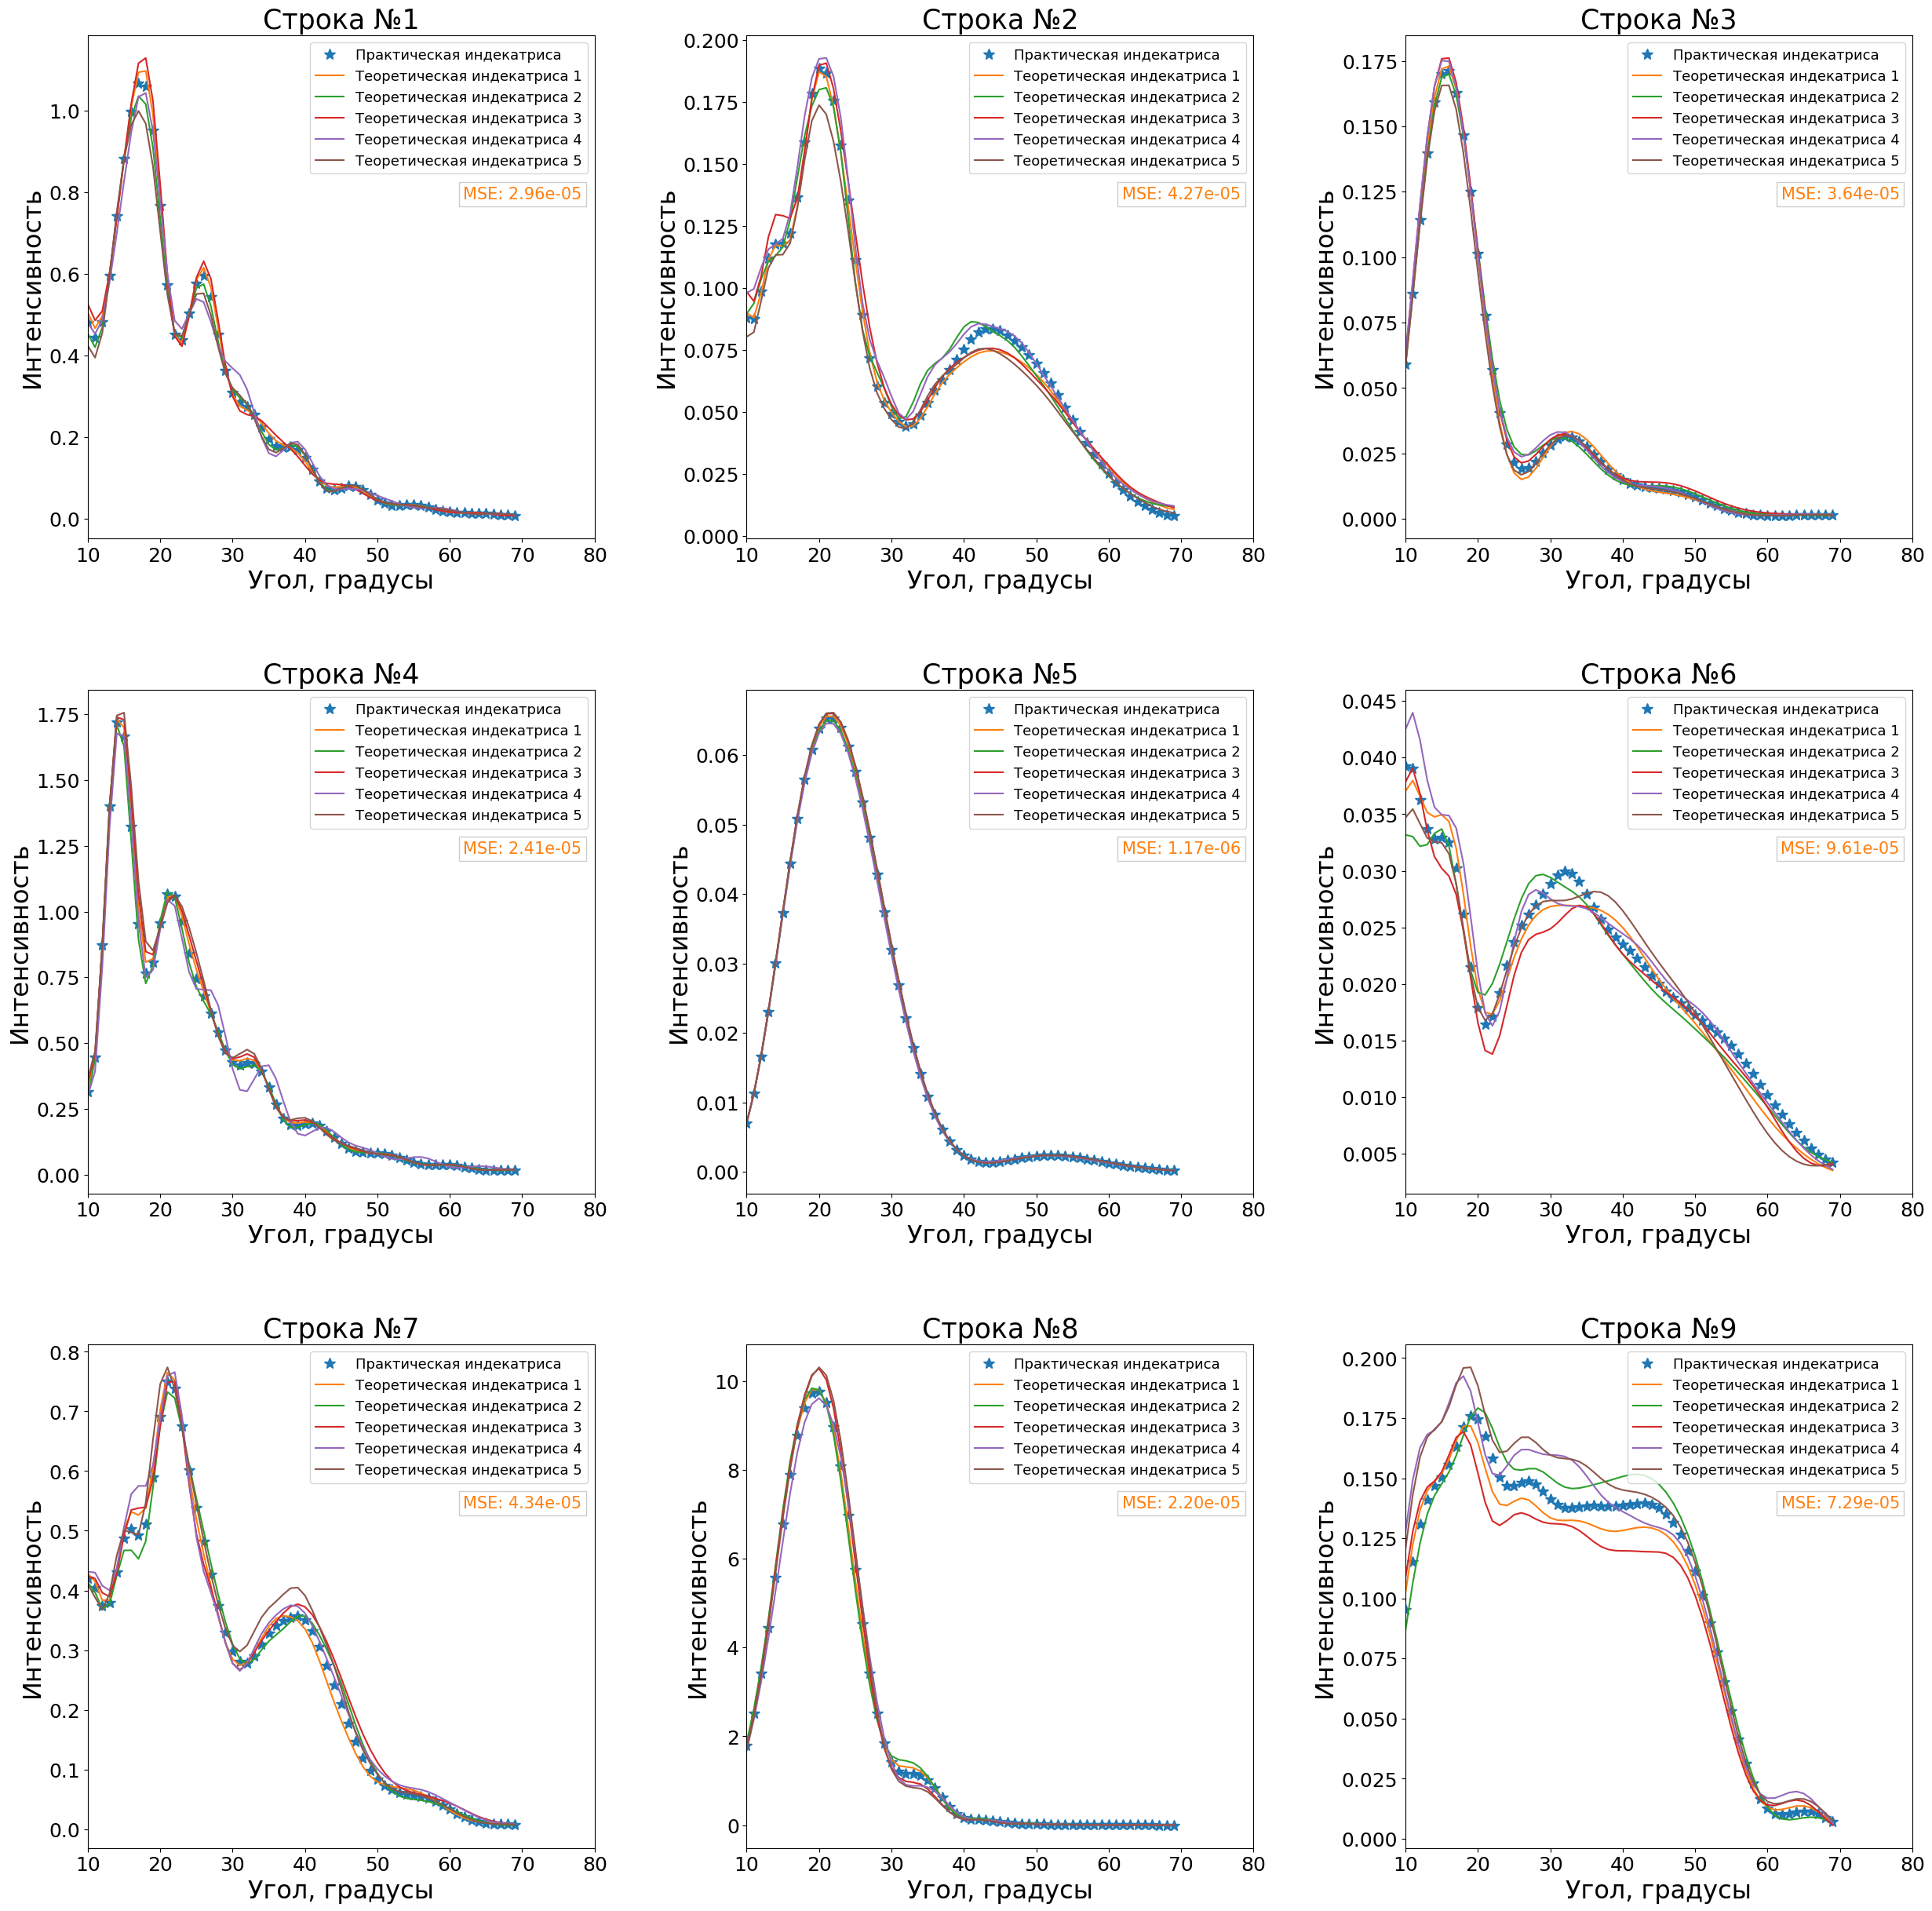

In [73]:
import matplotlib.pyplot as plt

# Общее количество графиков
num_plots = 9  
# Количество строк
rows = 3  
# Количество столбцов
cols = 3  

fig, axes = plt.subplots(rows, cols, figsize=(30, 30))

# Итерация по всем графикам
for i in range(num_plots):

    # Определение текущих строк и столбцов
    row = i // cols
    col = i % cols
    
    # Первые 5 индексов из ind для Train
    row_indices_train = ind[i][:5]  

    # Получение значений интенсивности от угла для выбранных строк
    intensities_test = X_test_weighted[i]
    intensities_train = X_train_weighted[row_indices_train]

    # Получение углы от 10 до 69 градусов для оси X
    angles = range(10, 70)

    # Список меток для легенды
    labels_train = ['Теоретическая индекатриса {}'.format(i+1) for i in range(len(row_indices_train))]

    # График практической индекатрисы на текущем подграфике
    axes[row, col].plot(angles, intensities_test, label='Практическая индекатриса', marker='*', markersize=10, linestyle='None') 

    # Рассчет mse для лучшего соответствия
    mse = (mean_squared_error(X_train_weighted[ind[i][0]], X_test_weighted[i], multioutput='raw_values')) / ((np.sum(X_train_weighted[ind[i][0]])**2) / len(X_train_weighted[ind[i][0]]))

    # Отображение MSE на графике
    axes[row, col].text(0.975, 0.7, 'MSE: {:.2e}'.format(mse[0]),
                    verticalalignment='top', horizontalalignment='right',
                    transform=axes[row, col].transAxes,
                    color='#ff7f0e', fontsize=15, bbox=dict(facecolor='white', alpha=0.2))


    # Графики теоретических индекатрис на текущем подграфике
    for j, intensities in enumerate(intensities_train):
        axes[row, col].plot(angles, intensities, label=labels_train[j]) 

    # Легенда на текущем подграфике
    axes[row, col].legend(fontsize=13, loc='upper right') 

    # Подписи осей и заголовок на текущем подграфике
    axes[row, col].set_xlabel('Угол, градусы', fontsize=23)  
    axes[row, col].set_ylabel('Интенсивность', fontsize=23) 
    axes[row, col].set_title('Строка №{}'.format(i+1), fontsize=25) 

    # Размер шрифта делений на осях
    axes[row, col].tick_params(axis='both', labelsize=18) 

    axes[row, col].set_xlim(10, 80)

# Увеличение расстояния между графиками
plt.subplots_adjust(hspace=0.3, wspace=0.3)  
plt.show()
